# Active site analysis

# Imports

In [1]:
import MDAnalysis as mda
import MDAnalysis.analysis.distances
import MDAnalysis.transformations
# import BioSimSpace as bss
import numpy as np
import nglview as nv
import os
import matplotlib.pyplot as plt


# Functions

In [10]:
def get_universe(file_path: str) -> tuple:
    """
    get PARM7, DCD files and return universe
    """
    topology = file_path + "somd.prm7"
    trajectory = file_path + "traj000000002.dcd"
    if not os.path.isfile(trajectory):
        trajectory = file_path + "traj000000001.dcd"
    return mda.Universe(topology, trajectory, topology_format="PARM7")


def get_coumarin_ring(ligand_group: mda.AtomGroup) -> mda.AtomGroup:
    """
    return atom group containing coumarin ring atoms
    """
    coumarin_ring_selection = "name C02 C03 C04 O C06 C08 C09 C15 C C17"
    return ligand_group.select_atoms(coumarin_ring_selection)


def get_indole_rings(protein_group: mda.AtomGroup) -> mda.AtomGroup:
    """
    find tryptophan 82 and return its rings as an atom group
    """
    tryptophan = protein_group.select_atoms("resname TRP and resid 82")
    indole_ring_selection = "name CG CD1 NE1 CE2 CZ2 CH2 CZ3 CE3 CD2"
    return tryptophan.select_atoms(indole_ring_selection)


def get_pyrrole_ring(indole_ring_group: mda.AtomGroup) -> mda.AtomGroup:
    pyrrole_ring_selections = "name CD1 CG CD2 CE2 NE1"
    return indole_ring_group.select_atoms(pyrrole_ring_selections)


def get_lactone_ring(coumarin_ring_group: mda.AtomGroup) -> mda.AtomGroup:
    """
    return lactone part of coumarin ring
    """
    lactone_ring_selections = "name C04 O C06 C08 C09 C15"
    return coumarin_ring_group.select_atoms(lactone_ring_selections)


def get_benzene_ring(reference_group: mda.AtomGroup, selection: str) -> mda.AtomGroup:
    """
    take a bicyclic atom group and select its benzene ring
    """
    return reference_group.select_atoms(selection)


In [11]:
file_path = "../outputs/SOMD/lig_h_1~lig_h_13/bound/lambda_1.0000/"
universe = get_universe(file_path)
workflow = [mda.transformations.unwrap(universe.atoms)]
universe.trajectory.add_transformations(*workflow)
protein = universe.select_atoms("protein")
ligand = universe.select_atoms("resname LIG")
carbonyl_oxygen = ligand.select_atoms("name O1")
carbonyl_com = carbonyl_oxygen.positions
carbonyl_com


array([[42.57463 , 44.733116, 29.687788]], dtype=float32)

In [12]:
tryptophan = protein.select_atoms("resid 82")
ligand_and_protein = ligand + tryptophan + protein

view = nv.show_mdanalysis(ligand_and_protein)
view.clear_representations()
view.add_surface("protein", opacity=0.4, color="white")
view.add_surface("82", color="white", opacity=0.2)
view.add_ball_and_stick("82")
view.add_ball_and_stick("LIG")
print(view.representations)
# view._remove_representation()
# view.add_representation("ball+stick", selection=tryptophan)
view

[]


NGLWidget(max_frame=499)

In [ ]:
view.download_image("../../plots/active_site_distances/pocket_lig_2_ts_377.pdf")

In [ ]:
view

In [ ]:
view.download_image("../../plots/active_site_distances/pocket_lig_2_ts_128.pdf")

In [ ]:
water = universe.select_atoms("resid 9784")
# water.positions
hydrogen = water.select_atoms("name H1")
hydrogen.positions

In [ ]:
view = nv.show_mdanalysis(ligand)
view

In [ ]:
view.download_image("../../plots/active_site_distances/ligand_2_pose_ts_1.pdf")

In [ ]:
dist = mda.analysis.distances.distance_array(carbonyl_com, water.positions)
dist

In [ ]:
view = nv.show_mdanalysis(universe)
view.add_representation("ball+stick")
view

In [5]:

water_residue_ids = []
water_residue_names = []
for resid in universe.residues.resids:
    all_residues = universe.select_atoms(f"resid {resid}")
    resiude_id = all_residues.residues.resids[0]
    residue_name = all_residues.residues.resnames[0]
    if residue_name == "WAT":
        water_residue_ids.append(resiude_id)
        water_residue_names.append(residue_name)

In [6]:
n_frames = len(universe.trajectory)
close_water_ids = []
water_ligand_distances = []
for i in range(len(water_residue_ids)):
    water_residue_id = water_residue_ids[i]
    # print(water_residue_id)
    water = universe.select_atoms(f"resid {water_residue_id}")
    for frame in range(n_frames):
        universe.trajectory[frame]
        water_com = water.positions
        water_ligand_distance = mda.analysis.distances.distance_array(carbonyl_com, water_com)[0]
        water_ligand_distances.append(water_ligand_distance)

        
# view = nv.show_mdanalysis(lig_wat)
# view.add_representation("ball+stick", selection="protein")
# view

KeyboardInterrupt: 

In [ ]:
for distance in water_ligand_distance:
    if distance <= 6.0:
        close_water_ids.append(water_residue_id)

In [ ]:
histidine = universe.select_atoms("resid 250")
arginine = universe.select_atoms("resid 197")


In [ ]:
string_ids = str(close_water_ids).replace("[","").replace("]","").replace(","," ")
close_waters = universe.select_atoms(f"resid {string_ids}")
ligand_in_active_site = close_waters + ligand + histidine + arginine
# ligand_in_active_site
view = nv.show_mdanalysis(ligand_in_active_site)
view.add_representation("ball+stick")
view

In [ ]:
file_path = "../outputs/SOMD/lig_h_1~lig_h_13/bound/lambda_1.0000/"
u = get_universe(file_path)

view = nv.show_mdanalysis(u)
# view.add_representation("ball+stick", selection="protein")
view

# Get all data

In [3]:
ligand_indices_all = np.arange(2, 17, 1)
ligand_indices = np.delete(ligand_indices_all, 10)
ligand_data = []
tryptophan_data = []
trajectories = []
bonding_data = []
universes = []
for i in ligand_indices:
    path = f"../outputs/SOMD/lig_h_1~lig_h_{i}/bound/lambda_1.0000/"
    print(path)
    universe = get_universe(path)
    print("got universe")
    workflow = [mda.transformations.unwrap(universe.atoms)]
    print("unwrapping workflow")
    universe.trajectory.add_transformations(*workflow)
    universes.append(universe)
    print("added transformation")
    trajectories.append(universe.trajectory)
    # times = [frame.time for frame in trajectory]

    protein = universe.select_atoms("protein")
    indole_ring = get_indole_rings(protein)
    pyrrole_ring = get_pyrrole_ring(indole_ring)
    indole_benzene_selection = "name CH2 CZ2 CE2 CD2 CE3 CZ3"
    indole_benzene = get_benzene_ring(indole_ring, indole_benzene_selection)
    tryptophan_data.append((indole_ring, pyrrole_ring, indole_benzene))
    
    ligand = universe.select_atoms("resname LIG")
    coumarin_ring = get_coumarin_ring(ligand)
    lactone_ring = get_lactone_ring(coumarin_ring)
    coumarin_benzene_selection = "name C02 C03 C04 C15 C C17"
    coumarin_benzene = get_benzene_ring(coumarin_ring, coumarin_benzene_selection)
    ligand_data.append((coumarin_ring, lactone_ring, coumarin_benzene))

    bonding_data.append((protein, ligand))

    

../outputs/SOMD/lig_h_1~lig_h_2/bound/lambda_1.0000/


got universe
unwrapping workflow
added transformation
../outputs/SOMD/lig_h_1~lig_h_3/bound/lambda_1.0000/
got universe
unwrapping workflow
added transformation
../outputs/SOMD/lig_h_1~lig_h_4/bound/lambda_1.0000/
got universe
unwrapping workflow
added transformation
../outputs/SOMD/lig_h_1~lig_h_5/bound/lambda_1.0000/
got universe
unwrapping workflow
added transformation
../outputs/SOMD/lig_h_1~lig_h_6/bound/lambda_1.0000/
got universe
unwrapping workflow
added transformation
../outputs/SOMD/lig_h_1~lig_h_7/bound/lambda_1.0000/
got universe
unwrapping workflow
added transformation
../outputs/SOMD/lig_h_1~lig_h_8/bound/lambda_1.0000/
got universe
unwrapping workflow
added transformation
../outputs/SOMD/lig_h_1~lig_h_9/bound/lambda_1.0000/
got universe
unwrapping workflow
added transformation
../outputs/SOMD/lig_h_1~lig_h_10/bound/lambda_1.0000/
got universe
unwrapping workflow
added transformation
../outputs/SOMD/lig_h_1~lig_h_11/bound/lambda_1.0000/
got universe
unwrapping workflow
ad

In [8]:
ligand_data = []
tryptophan_data = []
trajectories = []
bonding_data = []
universes = []
path = f"../outputs/SOMD/lig_h_1~lig_h_13/bound/lambda_1.0000/"
print(path)
universe = get_universe(path)
print("got universe")
workflow = [mda.transformations.unwrap(universe.atoms)]
print("unwrapping workflow")
universe.trajectory.add_transformations(*workflow)
universes.append(universe)
print("added transformation")
trajectories.append(universe.trajectory)
# times = [frame.time for frame in trajectory]

protein = universe.select_atoms("protein")
indole_ring = get_indole_rings(protein)
pyrrole_ring = get_pyrrole_ring(indole_ring)
indole_benzene_selection = "name CH2 CZ2 CE2 CD2 CE3 CZ3"
indole_benzene = get_benzene_ring(indole_ring, indole_benzene_selection)
tryptophan_data.append((indole_ring, pyrrole_ring, indole_benzene))

ligand = universe.select_atoms("resname LIG")
coumarin_ring = get_coumarin_ring(ligand)
lactone_ring = get_lactone_ring(coumarin_ring)
coumarin_benzene_selection = "name C02 C03 C04 C15 C C17"
coumarin_benzene = get_benzene_ring(coumarin_ring, coumarin_benzene_selection)
ligand_data.append((coumarin_ring, lactone_ring, coumarin_benzene))

bonding_data.append((protein, ligand))

../outputs/SOMD/lig_h_1~lig_h_13/bound/lambda_1.0000/
got universe
unwrapping workflow
added transformation


# C7 distance to L144

NGLWidget(max_frame=499)

In [ ]:
distances_1 = []
distances_2 = []

for i in range(len(trajectories)):
    delta_carbons_distance_1 = []
    delta_carbons_distance_2 = []
    for frame in trajectories[0]: 
        leucine = bonding_data[0][1].select_atoms("resid 144")
        ligand = bonding_data[0][2]
        delta_carbon_1 = leucine.select_atoms("name CD1").center_of_mass()
        delta_carbon_2 = leucine.select_atoms("name CD2").center_of_mass()
        ligand_c7 = ligand.select_atoms("name C02").center_of_mass()
        distance_1 = mda.analysis.distances.distance_array(ligand_c7, delta_carbon_1)
        distance_2 = mda.analysis.distances.distance_array(ligand_c7, delta_carbon_2)
        delta_carbons_distance_1.append((frame.time, distance_1[0][0]))
        delta_carbons_distance_2.append((frame.time, distance_2[0][0]))
    delta_carbons_distance_1 = np.asarray(delta_carbons_distance_1)
    delta_carbons_distance_2 = np.asarray(delta_carbons_distance_2)

    mean_distance_1 = np.mean(delta_carbons_distance_1[:,1])
    std_distance_1 = np.std(delta_carbons_distance_1[:,1])
    mean_distance_2 = np.mean(delta_carbons_distance_2[:,1])
    std_distance_2 = np.std(delta_carbons_distance_2[:,1])

    distances_1.append((delta_carbons_distance_1[:,0], delta_carbons_distance_1[:,1], mean_distance_1, std_distance_1))
    distances_2.append((delta_carbons_distance_2[:,0], delta_carbons_distance_2[:,1], mean_distance_2, std_distance_2))
distances_1 = np.asarray(distances_1)
distances_2 = np.asarray(distances_2)





In [ ]:
chosen_indices = [4, 7, -1]
for i in chosen_indices:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    ax.plot(distances_2[i][0][:], distances_2[i][1][:], label=f"ligand {ligand_indices[i]}")
    ax.set_xlabel("time (ps)")
    ax.set_ylabel(r"C$_7$ - C$_{\delta}^2$ distance ($\AA$)")

    ax.set_title(f"avg. ({distances_2[i][2]:.3f} \u00B1 {distances_2[0][3]:.3f}) \u212B")
    ax.legend(loc="upper left")
    fig.savefig(f"../../plots/active_site_distances/c7_leu_distance_{ligand_indices[0]}.pdf")
    plt.show()
    
    
    

In [ ]:
chosen_indices = [4, 7, -1]
for i in chosen_indices:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    ax.plot(distances_1[i][0][:], distances_1[i][1][:], label=f"ligand {ligand_indices[i]}")
    ax.set_xlabel("time (ps)")
    ax.set_ylabel(r"C$_7$ - C$_{\delta}^2$ distance ($\AA$)")

    ax.set_title(f"avg. ({distances_1[i][2]:.3f} \u00B1 {distances_1[i][3]:.3f}) \u212B")
    ax.legend(loc="upper left")
    # fig.savefig(f"../../plots/active_site_distances/c7_leu_distance_{ligand_indices[i]}.pdf")
    plt.show()

In [ ]:
nv.show_mdanalysis(leucine)

# Centroid distances between coumarin and indole

In [ ]:
len(ligand_data)

In [9]:
distances = []
chosen_indices = [0]
for i in chosen_indices:
    print(f"run {i+1}")
    coumarin_indole_distances = []
    coumarin_centroids = []
    indole_centroids = []
    coumarin_ring = ligand_data[i][0]
    lactone_ring = ligand_data[i][1]
    coumarin_benzene = ligand_data[i][2]
    indole_ring = tryptophan_data[i][0]
    pyrrole_ring = tryptophan_data[i][1]
    indole_benzene = tryptophan_data[i][2]
    universe = universes[i]
    n_frames = len(universe.trajectory)
    print("got all data for this run")
    for frame in range(n_frames):
        universe.trajectory[frame]
        print(f"at frame {frame}")
        coumarin_centroid = coumarin_ring.centroid()
        indole_centroid = indole_ring.centroid()
        print("got centroids")
        coumarin_indole_distance = mda.analysis.distances.distance_array(coumarin_centroid, indole_centroid)
        print("got distance")
        coumarin_indole_distances.append((universe.trajectory[frame].time, coumarin_indole_distance[0][0]))
        coumarin_centroids.append((universe.trajectory[frame].time, coumarin_centroid[0]))
        indole_centroids.append((universe.trajectory[frame].time, indole_centroid[0]))
        print("done appending")
    print("converting to arrays")
    coumarin_indole_distances = np.array(coumarin_indole_distances)
    coumarin_centroids = np.array(coumarin_centroids)
    indole_centroids = np.array(indole_centroids)
    mean_distance = np.mean(coumarin_indole_distances[:,1])
    std_distance = np.std(coumarin_indole_distances[:,1])
    distances.append((coumarin_indole_distances[:,0], coumarin_indole_distances[:,1], mean_distance, std_distance))
distances = np.array(distances)
np.save("../outputs/coumarin_indole_distances.npy", distances)

run 1
got all data for this run
at frame 0
got centroids
got distance
done appending
at frame 1
got centroids
got distance
done appending
at frame 2
got centroids
got distance
done appending
at frame 3
got centroids
got distance
done appending
at frame 4
got centroids
got distance
done appending
at frame 5
got centroids
got distance
done appending
at frame 6
got centroids
got distance
done appending
at frame 7
got centroids
got distance
done appending
at frame 8
got centroids
got distance
done appending
at frame 9
got centroids
got distance
done appending
at frame 10
got centroids
got distance
done appending
at frame 11
got centroids
got distance
done appending
at frame 12
got centroids
got distance
done appending
at frame 13
got centroids
got distance
done appending
at frame 14
got centroids
got distance
done appending
at frame 15
got centroids
got distance
done appending
at frame 16
got centroids
got distance
done appending
at frame 17
got centroids
got distance
done appending
at fra

/tmp/ipykernel_319185/2362861601.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  distances = np.array(distances)


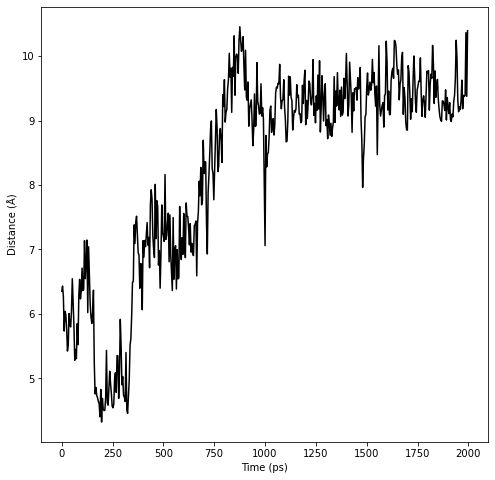

In [2]:
distances = np.load("../outputs/coumarin_indole_distances.npy", allow_pickle=True)
for i in range(len(distances)):
    time = distances[i][0]
    distance = distances[i][1]
    mean = distances[i][2]
    std = distances[i][3]
    plt.figure(figsize=(8,8))
    # plt.ylim(2,10)
    plt.plot(time, distance, "k-")
    plt.xlabel("Time (ps)")
    plt.ylabel(f"Distance (\u212B)")
    plt.savefig(f"../../plots/active_site_distances/coumarin_indole_distance_{i}.png", transparent=True)
    plt.show()

In [ ]:
distances = []
for i in range(len(trajectories)):
    coumarin_indole_distances = []
    coumarin_centroids = []
    indole_centroids = []
    for frame in trajectories[i]:
        coumarin_ring = ligand_data[i][0]
        lactone_ring = ligand_data[i][1]
        coumarin_benzene = ligand_data[i][2]
        indole_ring = tryptophan_data[i][0]
        pyrrole_ring = tryptophan_data[i][1]
        indole_benzene = tryptophan_data[i][2]
        coumarin_centroid = coumarin_ring.centroid()
        indole_centroid = indole_ring.centroid()
        coumarin_indole_distance = mda.analysis.distances.distance_array(coumarin_centroid, indole_centroid)
        coumarin_indole_distances.append((frame.time, coumarin_indole_distance[0][0]))
        coumarin_centroids.append((frame.time, coumarin_centroid[0]))
        indole_centroids.append((frame.time, indole_centroid[0]))
    coumarin_indole_distances = np.asarray(coumarin_indole_distances)
    coumarin_centroids = np.asarray(coumarin_centroids)
    indole_centroids = np.asarray(indole_centroids)

    mean_distance = np.mean(coumarin_indole_distances[:,1])
    std_distance = np.std(coumarin_indole_distances[:,1])

    distances.append((coumarin_indole_distances[:,0], coumarin_indole_distances[:,1], mean_distance, std_distance))

distances = np.asarray(distances)
    


In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.plot(distances[0][0][:], distances[0][1][:], label=f"ligand {chosen_indices[0]}")
ax.set_xlabel("time (ps)")
ax.set_ylabel(r"coumarin - indole distance ($\AA$)")
ax.set_title(f"avg. distance ({distances[0][2]:.3} \u00B1 {distances[0][3]:.3f}) \u212B")
ax.legend(loc="upper left")
# fig.savefig(f"../../plots/active_site_distances/coumarin_inodole_distance_{ligand_indices[0]}.pdf")
plt.show()


In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.plot(distances[1][0][:], distances[1][1][:], label=f"ligand {chosen_indices[1]}")
ax.set_xlabel("time (ps)")
ax.set_ylabel(r"coumarin - indole distance ($\AA$)")
ax.set_title(f"avg. distance ({distances[1][2]:.3} \u00B1 {distances[1][3]:.3f}) \u212B")
ax.legend(loc="upper left")
# fig.savefig(f"../../plots/active_site_distances/coumarin_inodole_distance_{ligand_indices[0]}.pdf")
plt.show()

In [ ]:
chosen_indices = ligand_indices
chosen_indices = range(0, len(trajectories))
for i in chosen_indices:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    ax.plot(distances[i][0][:], distances[i][1][:], label=f"ligand {ligand_indices[i]}")
    ax.set_xlabel("time (ps)")
    ax.set_ylabel(r"coumarin - indole distance ($\AA$)")
    ax.set_title(f"avg. distance ({distances[i][2]:.3} \u00B1 {distances[i][3]:.3f}) \u212B")
    ax.legend(loc="upper left")
    fig.savefig(f"../../plots/active_site_distances/coumarin_inodole_distance_{ligand_indices[i]}.pdf")
    plt.show()
    

# Ring centroid distances 

In [ ]:
for i in range(len(trajectories)):
    lactone_pyrrole_distances = []
    bb_distances = []
    for frame in trajectories[i]:
        times = ligand_data[i][0]
        lactone_ring = ligand_data[i][2]
        coumarin_benzene = ligand_data[i][3]
        pyrrole_ring = tryptophan_data[i][2]
        indole_benzene = tryptophan_data[i][2]

        lactone_centroid = lactone_ring.centroid()
        pyrrole_centroid = pyrrole_ring.centroid()
        coumarin_b_centroid = coumarin_benzene.centroid()
        indole_b_centroid = indole_benzene.centroid()
        
        lactone_pyrrole_distance = mda.analysis.distances.distance_array(lactone_centroid, pyrrole_centroid)
        lactone_pyrrole_distances.append((frame.time, lactone_pyrrole_distance[0][0]))

        bb_distance = mda.analysis.distances.distance_array(coumarin_b_centroid, indole_b_centroid)
        bb_distances.append((frame.time, bb_distance[0][0]))
        
    lactone_pyrrole_distances = np.asarray(lactone_pyrrole_distances)
    bb_distances = np.asarray(bb_distances)

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10, 8)
    ax[0].plot(lactone_pyrrole_distances[:,0], lactone_pyrrole_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[0].set_title("lactone - pyrrole centroid")
    ax[1].plot(bb_distances[:,0], bb_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[1].set_title("coumarin benzene - indole benzene")
    # ax[2].plot(indole_centroids[:,0], indole_centroids[:,1], label=f"ligand {ligand_indices[i]}")
    # ax[2].set_title("indole centroid coordinates")
    ax[0].legend()
    ax[1].legend()
    # ax[2].legend()
    plt.show()
    


# Carbonyl oxygen distance from HIS274 & ARG220

### Should do in terms of water-mediated hydrogen bonding

In [ ]:
for i in range(len(trajectories)):
    histidine_distances = []
    arginine_distances = []
    for frame in trajectories[i]:
        time = bonding_data[i][0]
        arginine = bonding_data[i][1].select_atoms("resid 197")
        histidine = bonding_data[i][1].select_atoms("resid 250")
        ligand = bonding_data[i][2]
        arginine_nitrogen = arginine.select_atoms("name NH2").center_of_mass()
        histidine_nitrogen = histidine.select_atoms("name NE2").center_of_mass()
        carbonyl_oxygen = ligand.select_atoms("name O1").center_of_mass()
        print(arginine_nitrogen)
        histidine_distance = mda.analysis.distances.distance_array(carbonyl_oxygen, histidine_nitrogen)
        arginine_distance = mda.analysis.distances.distance_array(carbonyl_oxygen, arginine_nitrogen)

        histidine_distances.append((frame.time, histidine_distance[0][0]))
        arginine_distances.append((frame.time, arginine_distance[0][0]))
    histidine_distances = np.asarray(histidine_distances)
    arginine_distances = np.asarray(arginine_distances)

    mean_his_distance = np.mean(histidine_distances[:,1])
    std_his_distance = np.std(histidine_distances[:,1])
    mean_arg_distance = np.mean(arginine_distances[:,1])
    std_arg_distance = np.std(arginine_distances[:,1])

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10, 8)
    ax[0].plot(histidine_distances[:,0], histidine_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[1].plot(arginine_distances[:,0], arginine_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[0].set_xlabel("time (ps)")
    ax[0].set_ylabel("carbonyl - histidine")
    ax[1].set_ylabel("carbonyl - arginine")
    ax[1].set_xlabel("time (ps)")

    ax[0].set_title(f"avg. ({mean_his_distance:.3f} \u00B1 {std_his_distance:.3f}) \u212B")
    ax[1].set_title(f"avg. ({mean_arg_distance:.3f} \u00B1 {std_arg_distance:.3f}) \u212B")

    ax[0].legend(loc="upper left")
    ax[1].legend(loc="upper left")
    plt.show()

In [ ]:
ligand = bonding_data[-3][2]

In [ ]:
nv.show_mdanalysis(ligand)

In [ ]:
nv.show_mdanalysis(arginine)

In [ ]:
nv.show_mdanalysis(histidine)